<a href="https://colab.research.google.com/github/AsyrofiAnam/Klasifikasi_AlatPembersihRumah/blob/main/Klasifikasi_AlatPembersihRumah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#KLASIFIKASI ALAT PEMBERSIH RUMAH

#Import Necessary Libraries

In [ ]:
!pip install keras_preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers, models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers import Resizing, Rescaling

from pathlib import Path
import os.path
import random
import datetime

import matplotlib.cm as cm
import cv2
import seaborn as sns

sns.set_style('darkgrid')

from sklearn.metrics import classification_report, confusion_matrix
import itertools

#Load and Transform Data

In [ ]:
# Parameter dasar
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

# Path dataset
dataset = "/content/drive/MyDrive/AlatPembersihRumah"

# Melihat struktur folder dan jumlah file di tiap kelas
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"Ada {len(dirnames)} folder dan {len(filenames)} file di direktori: {dirpath}")

walk_through_dir(dataset)

Ada 4 folder dan 2 file di direktori: /content/drive/MyDrive/AlatPembersihRumah
Ada 0 folder dan 350 file di direktori: /content/drive/MyDrive/AlatPembersihRumah/Sikat_Lantai
Ada 0 folder dan 350 file di direktori: /content/drive/MyDrive/AlatPembersihRumah/Serokan_Sampah
Ada 0 folder dan 350 file di direktori: /content/drive/MyDrive/AlatPembersihRumah/Sapu_Ijuk
Ada 0 folder dan 350 file di direktori: /content/drive/MyDrive/AlatPembersihRumah/Kemoceng


#Placing Data into a DataFrame

In [ ]:
image_dir = Path(dataset)

# Dapatkan jalur file dan label
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Gabungkan jalur file dan label
image_df = pd.concat([filepaths, labels], axis=1)

<ipython-input-5-7f2a8ae770a4>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')


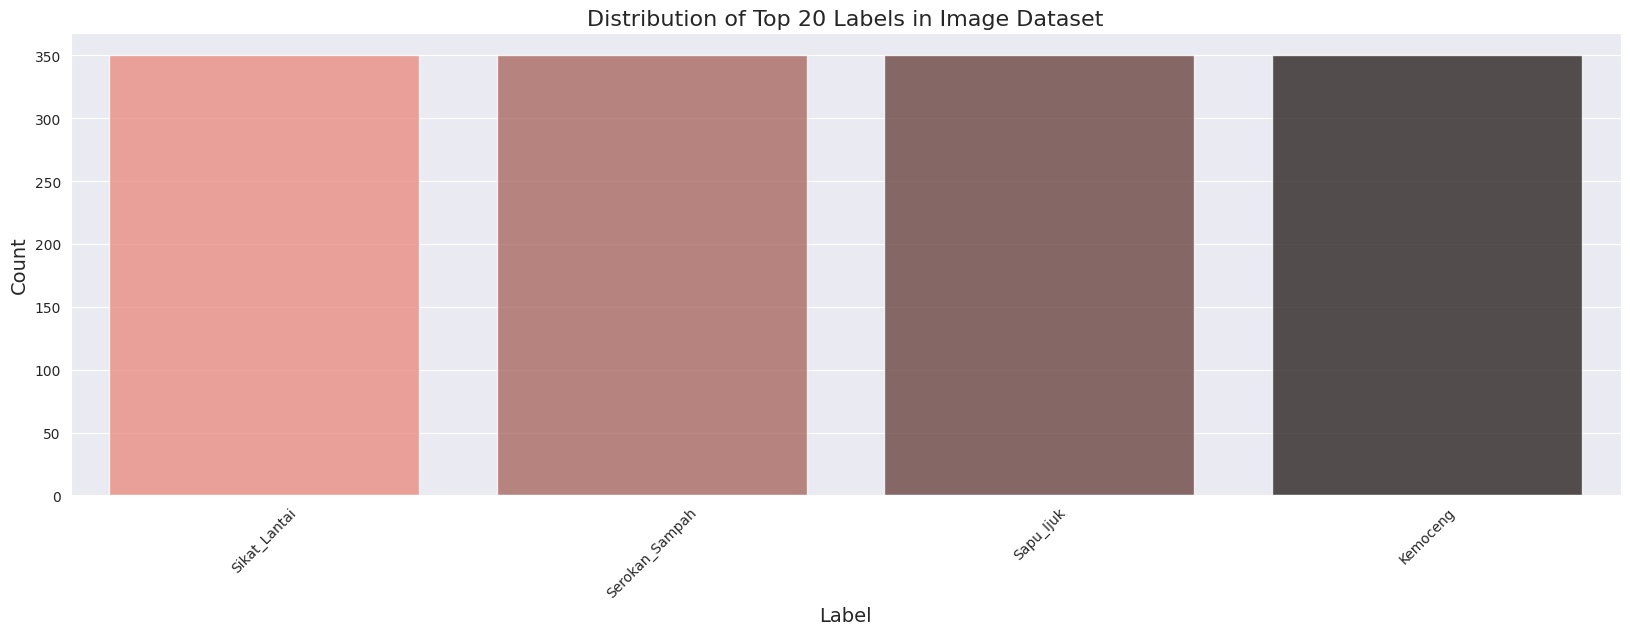

In [ ]:
# Dapatkan 20 label teratas
label_counts = image_df['Label'].value_counts()[:20]

plt.figure(figsize=(20, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')
plt.title('Distribution of Top 20 Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()

#Visualizing Images from the Dataset

<ipython-input-6-246a52a464a2>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = image_df.groupby('Label', group_keys=False).apply(lambda x: x.sample(2)).reset_index(drop=True)


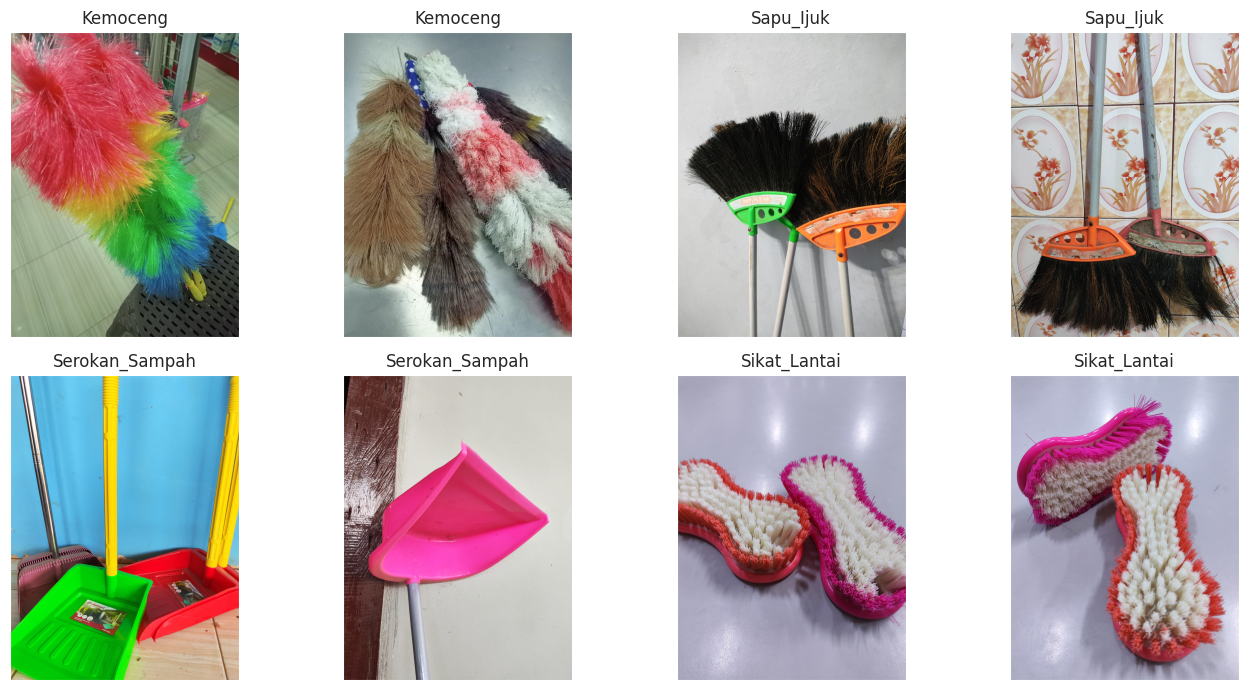

In [ ]:
# Ambil 2 gambar acak dari tiap kelas
sample_df = image_df.groupby('Label', group_keys=False).apply(lambda x: x.sample(2)).reset_index(drop=True)

# Plot gambar-gambar
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 7), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img = plt.imread(sample_df.Filepath[i])
    label = sample_df.Label[i]
    ax.imshow(img)
    ax.set_title(label)

plt.tight_layout()
plt.show()

#Computing Error Rate Analysis

In [ ]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # Membaaca gambar yang terkompres
    compressed_img = cv2.imread(temp_filename)

    # Dapatkan perbedaan absolut antara img1 dan img2 dan kalikan dengan skala
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality=quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image


def random_sample(path, extension=None):
    # Pilih gambar acak dari folder
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')

    items = list(items)

    p = random.choice(items)
    return p.as_posix()

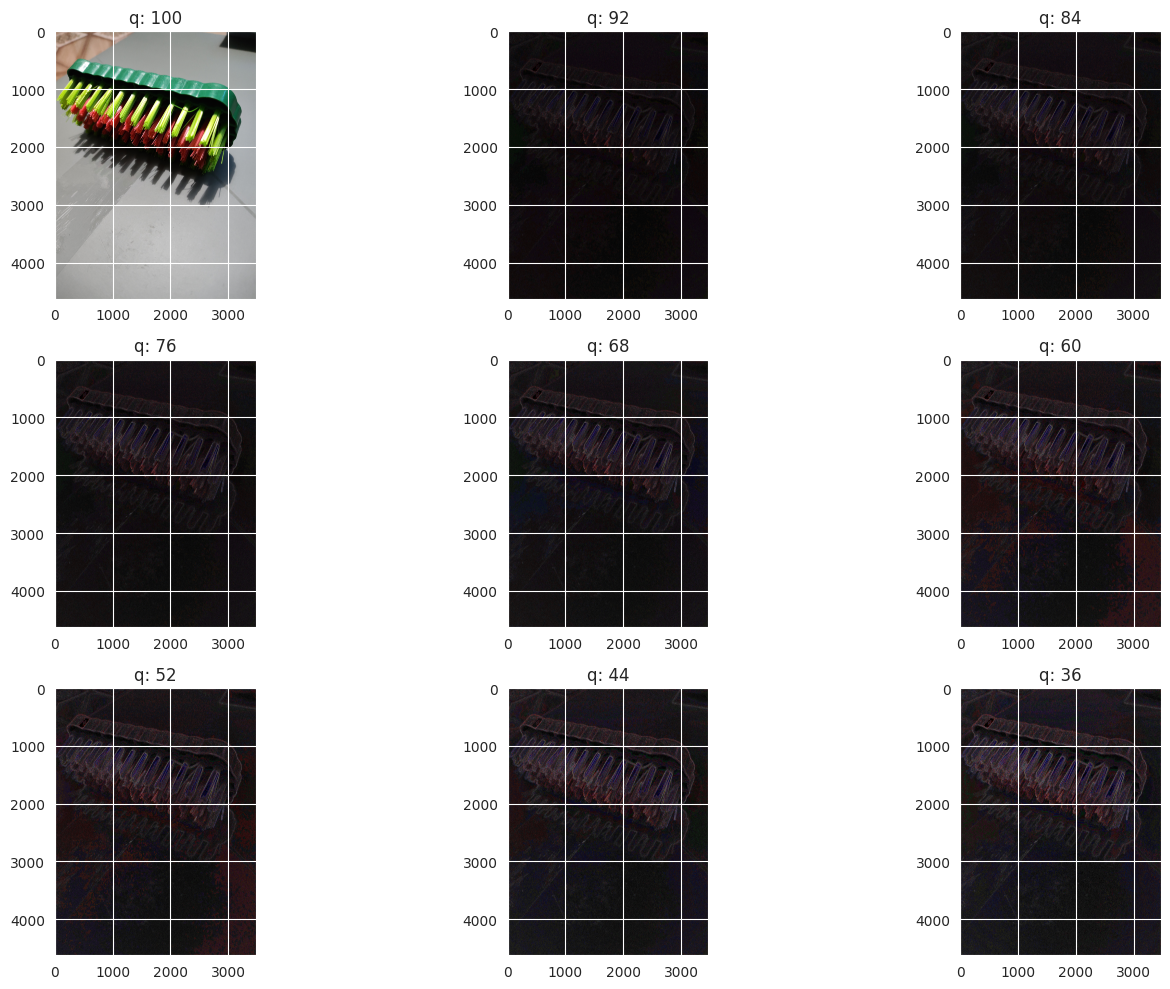

In [ ]:
# Lihat sampel acak dari kumpulan data dan terapkan ELA
sample_class = 'Sikat_Lantai'
dataset_path = '/content/drive/MyDrive/AlatPembersihRumah'
p = random_sample(f'{dataset_path}/{sample_class}')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0

init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows + 1):
    quality = init_val - (i-1) * 8  # Menurunkan kualitas kompresi untuk setiap gambar
    img = compute_ela_cv(path=p, quality=quality)

    if i == 1:
        img = orig.copy()  # Gambar asli di posisi pertama

    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)

plt.tight_layout()
plt.show()

#Data Preprocessing

In [ ]:
train_val_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42, stratify=image_df['Label'])


train_df, val_df = train_test_split(train_val_df, test_size=0.25, shuffle=True, random_state=42, stratify=train_val_df['Label'])

# Konfirmasi ukuran
print(f"Jumlah data latih: {len(train_df)}")
print(f"Jumlah data validasi: {len(val_df)}")
print(f"Jumlah data uji: {len(test_df)}")

Jumlah data latih: 840
Jumlah data validasi: 280
Jumlah data uji: 280


In [ ]:
# Membuat generator untuk data latih, validasi, dan uji
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

val_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
# Membuat data generator untuk training
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

# Membuat data generator untuk validasi
val_images = val_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

# Membuat data generator untuk testing
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 840 validated image filenames belonging to 4 classes.
Found 280 validated image filenames belonging to 4 classes.
Found 280 validated image filenames belonging to 4 classes.


In [ ]:
# Menghitung jumlah gambar per kelas pada data latih
train_class_counts = train_df.groupby('Label').size()
print("Jumlah gambar per kelas pada data latih:")
print(train_class_counts)

# Menghitung jumlah gambar per kelas pada data validasi
val_class_counts = val_df.groupby('Label').size()
print("Jumlah gambar per kelas pada data validasi:")
print(val_class_counts)

# Menghitung jumlah gambar per kelas pada data pengujian
test_class_counts = test_df.groupby('Label').size()
print("Jumlah gambar per kelas pada data pengujian:")
print(test_class_counts)

Jumlah gambar per kelas pada data latih:
Label
Kemoceng          210
Sapu_Ijuk         210
Serokan_Sampah    210
Sikat_Lantai      210
dtype: int64
Jumlah gambar per kelas pada data validasi:
Label
Kemoceng          70
Sapu_Ijuk         70
Serokan_Sampah    70
Sikat_Lantai      70
dtype: int64
Jumlah gambar per kelas pada data pengujian:
Label
Kemoceng          70
Sapu_Ijuk         70
Serokan_Sampah    70
Sikat_Lantai      70
dtype: int64


In [ ]:
# Langkah Augmentasi Data
augment = tf.keras.Sequential([
    layers.Resizing(224, 224),  # Mengubah ukuran gambar menjadi 224x224
    layers.Rescaling(1./255),  # Normalisasi pixel ke rentang [0, 1]
    layers.RandomFlip("horizontal"),  # Flipping acak gambar secara horizontal
    layers.RandomRotation(0.1),  # Rotasi acak gambar dengan range 0.1
    layers.RandomZoom(0.1),  # Zoom acak dengan range 0.1
    layers.RandomContrast(0.1),  # Kontras acak dengan range 0.1
])

#Training the Model

In [ ]:
# Muat MobileNetV2 sebagai model dasar
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Buat panggilan balik titik pemeriksaan
checkpoint_path = "alat_pembersih_rumah.weights.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Siapkan panggilan balik EarlyStopping untuk menghentikan pelatihan jika val_loss model tidak membaik selama 5 epoch
early_stopping = EarlyStopping(monitor = "val_loss",
                               patience = 5,
                               restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [16]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)


outputs = Dense(len(train_images.class_indices), activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = os.path.join(dir_name, experiment_name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    return TensorBoard(log_dir=log_dir)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=50,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "alat_pembersih_rumah"),
        checkpoint_callback,
        reduce_lr
    ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 672s 23s/step - accuracy: 0.3226 - loss: 3.6380 - val_accuracy: 0.8786 - val_loss: 0.3868 - learning_rate: 1.0000e-04
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 411s 15s/step - accuracy: 0.7089 - loss: 0.8646 - val_accuracy: 0.9464 - val_loss: 0.1826 - learning_rate: 1.0000e-04
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 449s 15s/step - accuracy: 0.8274 - loss: 0.4545 - val_accuracy: 0.9750 - val_loss: 0.0889 - learning_rate: 1.0000e-04
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 413s 15s/step - accuracy: 0.9166 - loss: 0.2654 - val_accuracy: 0.9857 - val_loss: 0.0493 - learning_rate: 1.0000e-04
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 386s 14s/step - accuracy: 0.9425 - loss: 0.1917 - val_accuracy: 0.9893 - val_loss: 0.0326 - learning_rate: 1.0000e-04
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 460s 15s/step - accuracy: 0.9581 - loss: 0.1424 - val_accuracy: 0.9929 - val_loss: 0.0225 - learning_rate: 1.0000e-04
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 460s 15s/step - accuracy: 

#Model Evaluation

In [17]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.00166
Test Accuracy: 100.00%


#Visualizing Loss Curves

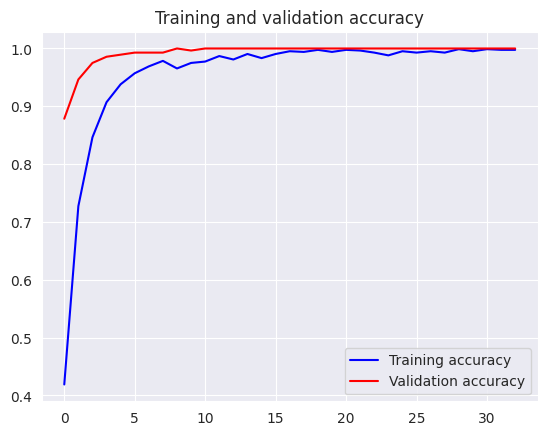

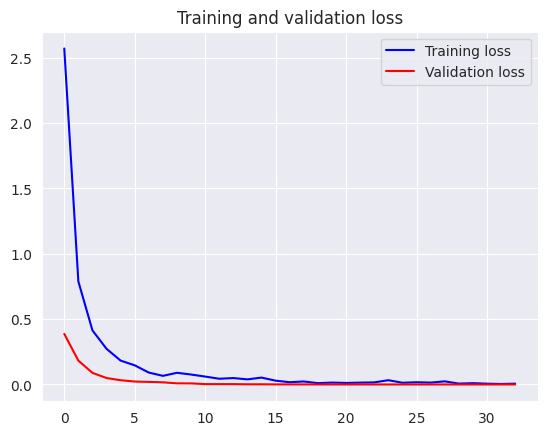

In [18]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

#Making Predictions on the Test Data

In [19]:
# Predict label test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Petakan label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

9/9 ━━━━━━━━━━━━━━━━━━━━ 58s 6s/step


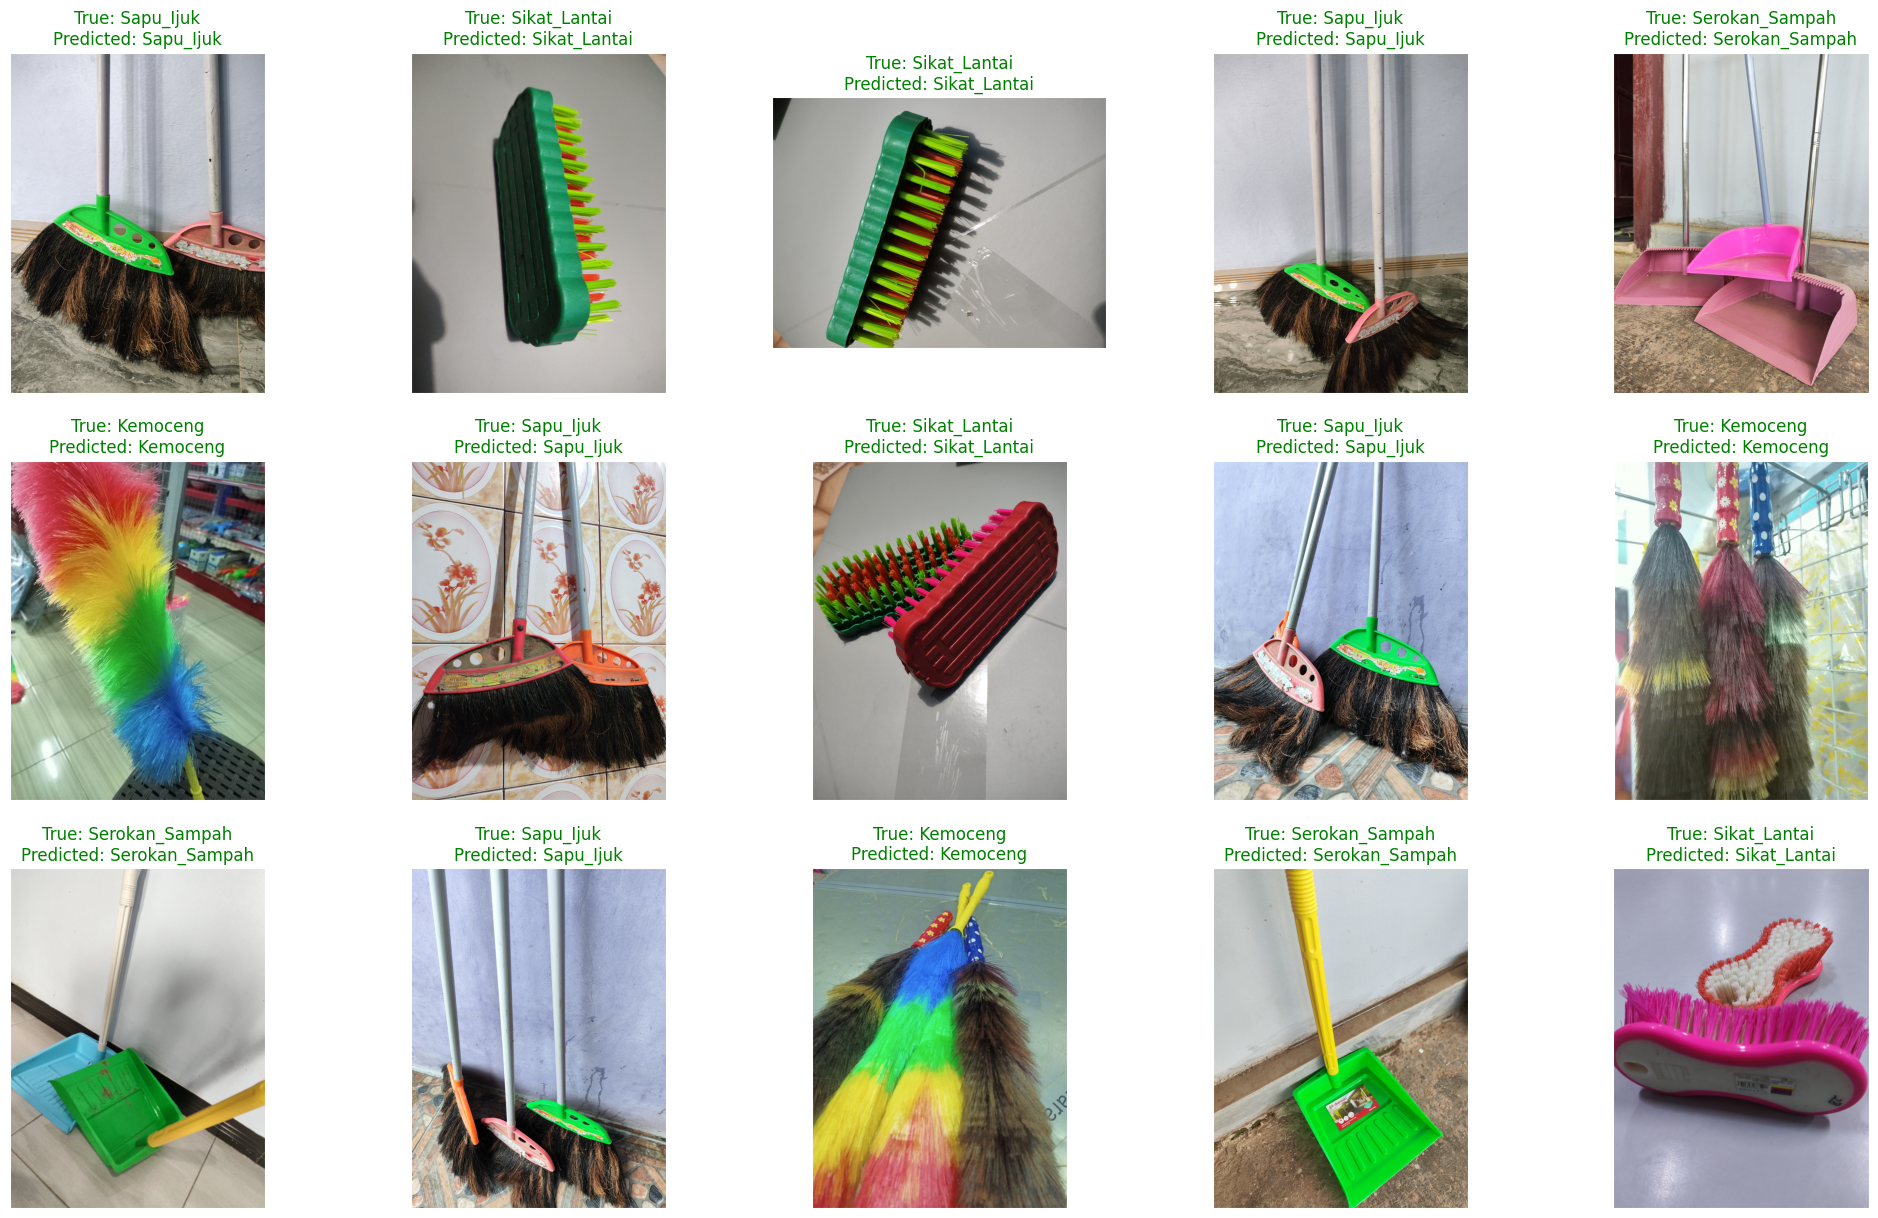

<Figure size 640x480 with 0 Axes>

In [20]:
# Menampilkan 25 gambar acak dari dataset dengan labelnya
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

#Plotting the Classification Reports and Confusion Matrix

In [21]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                precision    recall  f1-score   support

      Kemoceng       1.00      1.00      1.00        70
     Sapu_Ijuk       1.00      1.00      1.00        70
Serokan_Sampah       1.00      1.00      1.00        70
  Sikat_Lantai       1.00      1.00      1.00        70

      accuracy                           1.00       280
     macro avg       1.00      1.00      1.00       280
  weighted avg       1.00      1.00      1.00       280



In [22]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision  recall  f1-score  support
Kemoceng              1.0     1.0       1.0     70.0
Sapu_Ijuk             1.0     1.0       1.0     70.0
Serokan_Sampah        1.0     1.0       1.0     70.0
Sikat_Lantai          1.0     1.0       1.0     70.0
accuracy              1.0     1.0       1.0      1.0
macro avg             1.0     1.0       1.0    280.0
weighted avg          1.0     1.0       1.0    280.0

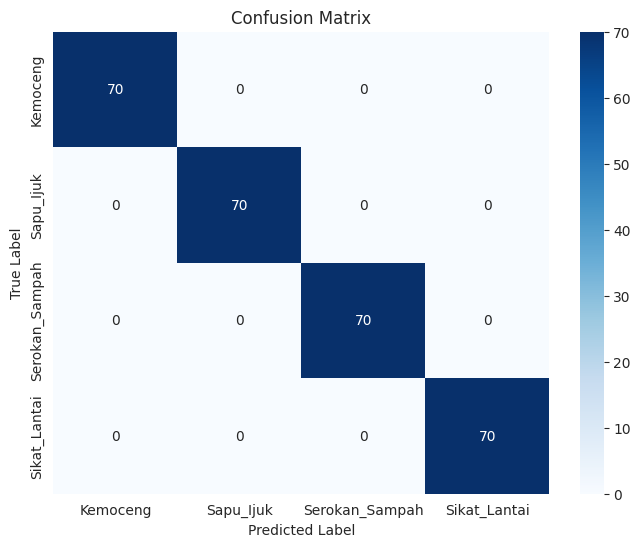

In [23]:
# Menghitung confusion matrix
cm = confusion_matrix(y_test, pred)

# Plot confusion matrix dengan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_images.class_indices.keys(), yticklabels=test_images.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#Grad-CAM Visualization

In [24]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))

    return cam_path


preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "Conv_1"
img_size = (224,224, 3)

# Remove last layer's softmax
model.layers[-1].activation = None

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
<ipython-input-24-11b785a06756>:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


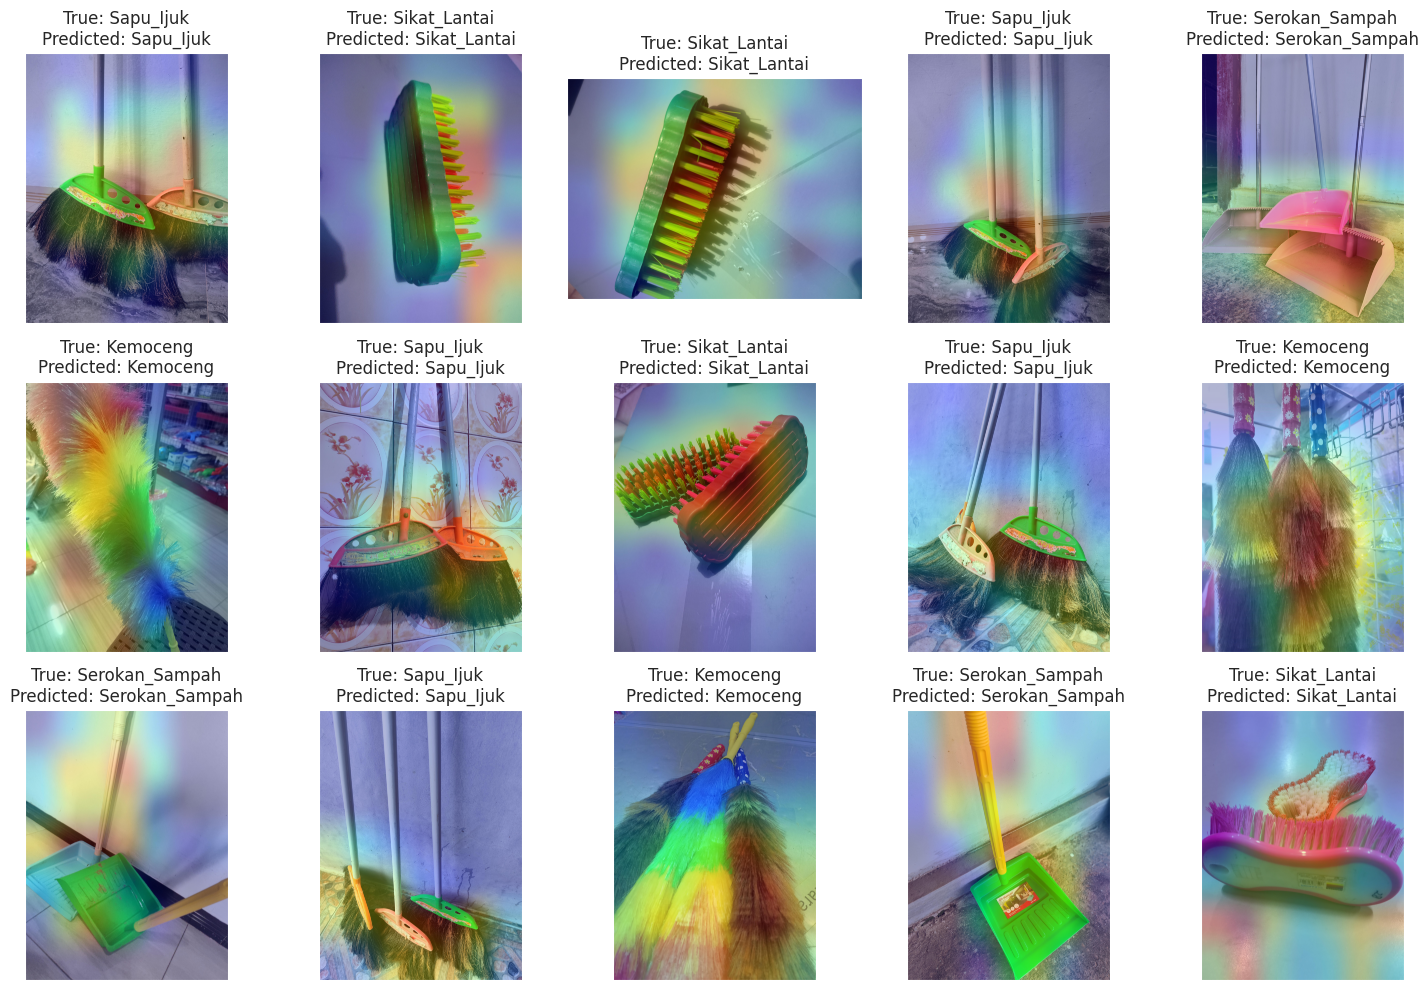

In [25]:
import matplotlib.cm as cm
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()
plt.show()